# DATA ACCESS

In [1]:
%matplotlib inline
from DTWpg import *
import requests
import pandas as pd
import matplotlib.pyplot as plt
import io
import json
from influxdb import DataFrameClient
import re
from pprint import pprint
from datetime import datetime
import os
from joblib import Parallel, delayed
import multiprocessing
import copy
from IPython.display import clear_output
import time

import random

import numpy as np
from collections import defaultdict

import matplotlib
import numpy as np
import math

from influxdb import DataFrameClient
from influxdb.exceptions import InfluxDBClientError, InfluxDBServerError
from os import getenv
import pymssql
import pandas as pd

from datetime import datetime
import pickle

from sklearn.cross_decomposition import PLSRegression
from scipy.special import erfinv
from scipy.stats import f
##influx
client = DataFrameClient('de-w-5000701.crc.de.abb.com', 8086, '', '', 'batch_pv_offline')

##mssql
server = "de-w-5000701.crc.de.abb.com"
print(server)
user = "sa"
password = "Q1w2e3r4t5"
conn = pymssql.connect(server, user, password, "BATCH_INSIGHT_DEMO")
get_pv_to_unit_url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchTrend/"
valuedict={}

labels = pd.read_csv("labels-20180507-cleaned.csv", header = None, delimiter="\t")
labelsAnonym = labels.loc[(labels[2] == "TAG/TAG_NAME") & ((labels[1].str.contains("^ba_")) | (labels[0].str.contains("^ba_"))), 0:1]

random.seed(42)
state = random.getstate()

de-w-5000701.crc.de.abb.com


The `get_pv_values()` function returns the values of a certain PV (`pvlist`) in a specified timeframe [`starttime`, `endtime`] in the database __batch_pv_basf_offline.autogen__. 

In [2]:
def get_pv_values(pvlist, starttime, endtime):

    query = "SELECT min(\"value\") as \"value\" FROM \"batch_pv_basf_offline\".\"autogen\".\"" + pvlist + "\" WHERE time >= \'" + starttime + "\' AND time <= \'" + endtime + "\' GROUP BY time(60s, 60s) FILL(previous)"

    run_step_pvs = None
    
    try:
        run_step_pvs = client.query(query)
    except Exception as e:
        print(e)
        print("error in get pv values in general utilities")

    valframe = {}

    if run_step_pvs is not None:
        valframe["start"] = starttime
        valframe["end"] = endtime
        valframe["name"] = pvlist
        if not len(run_step_pvs.keys()):
            return None
        for key in run_step_pvs.keys():

            pvtable = run_step_pvs[key]
#             pvtable = pvtable.interpolate(limit=10)
            pvtable= pvtable.dropna(how='all',axis=1)
            
            pvtable= pvtable.astype(float)
            pvtable = pvtable.interpolate(method='values')
            pvtable = pvtable.fillna(method='backfill')
            
#             nunique = pvtable.apply(pd.Series.nunique)
#             cols_to_drop = nunique[nunique == 1].index
#             pvtable=pvtable.drop(cols_to_drop,axis=1)
            
            ls=[]
            if len(list(pvtable)):
                ls = pvtable.value.values.tolist()

            if not ls or not len(ls):
                return None
            valframe["values"]= ls
        return valframe
    return None

`formatTime()` makes the time stamp collected from the metadata repository suitable to be used in the query to the database. 

In [3]:
def formatTime(time):
    return datetime.strptime(time,"%Y-%m-%dT%H:%M:%S.%f%z").strftime("%Y-%m-%d %H:%M:%S")

In [4]:
# Information we get for every batch run in recipe 421
# - BatchId
# - BatSTimeAC
# - BatETimeAC

get_all_batches_to_recipe_url="http://de-w-5000701.crc.de.abb.com:9090/api/batchinfo/421"

urlData = requests.get(get_all_batches_to_recipe_url).text
allBatch = pd.read_json(urlData)
allBatch.head()

,BatBatch,BatDcsName,BatDuration,BatETimeAC,BatEndTimeModelPhase,BatEquipment,BatLabelIds,BatLabels,BatMaterial,BatSTimeAC,BatStartTimeModelPhase,BatchId
0,37425,37425,179237,2014-11-15T01:49:52.000+0000,0001-01-01T00:00:00,"[UNIT_18, UNIT_01, UNIT_1A, UNIT_10]","[2, 34, 3, 4, 5]",[{'BlaDesc': 'Batch Abbruch Produkt muss in di...,"[{'BmaSapNo': '', 'BmaMatName': 'Sok.PM 10i', ...",2014-11-13T00:02:35.000+0000,0001-01-01T00:00:00,5080
1,37437,37437,213746,2014-11-16T00:59:44.000+0000,0001-01-01T00:00:00,"[UNIT_18, UNIT_01, UNIT_1A, UNIT_10]","[1, 34]","[{'BlaDesc': 'Batch Abbruch kein Produkt', 'Bl...","[{'BmaSapNo': '', 'BmaMatName': 'Sok.PM 10i', ...",2014-11-13T13:37:18.000+0000,0001-01-01T00:00:00,5081
2,37445,37445,142948,2014-11-16T17:56:19.000+0000,0001-01-01T00:00:00,"[UNIT_18, UNIT_01, UNIT_1A, UNIT_10]",[],[],"[{'BmaSapNo': '', 'BmaMatName': 'Sok.PM 10i', ...",2014-11-15T02:13:51.000+0000,0001-01-01T00:00:00,5082
3,37445,37445,142948,2014-11-16T17:56:19.000+0000,0001-01-01T00:00:00,"[UNIT_18, UNIT_01, UNIT_1A, UNIT_10]",[],[],"[{'BmaSapNo': '', 'BmaMatName': 'Sok.PM 10i', ...",2014-11-15T02:13:51.000+0000,0001-01-01T00:00:00,5083
4,37469,37469,169008,2014-11-18T17:24:37.000+0000,0001-01-01T00:00:00,"[UNIT_18, UNIT_01, UNIT_1A, UNIT_10]","[6, 11]","[{'BlaDesc': 'Batch nahe Optimum', 'BlaGroup':...","[{'BmaSapNo': '', 'BmaMatName': 'Sok.PM 10i', ...",2014-11-16T18:27:49.000+0000,0001-01-01T00:00:00,5084


The table above is a list of all the batches (428) contained in the 421 recipe.

In [5]:
# Start creating the data structure to contain all data.

recipe421 = dict()
for index, row in allBatch.iterrows():
    recipe421[row['BatchId']] = {'BatchId': row['BatchId'],
                                'BatSTimeAC': row['BatSTimeAC'],
                                'BatETimeAC': row['BatETimeAC'],
                                'Units': dict()}
print("Number of Batches: {}".format(len(recipe421)))
recipe421[5080]

Number of Batches: 428


{'BatchId': 5080,
 'BatSTimeAC': '2014-11-13T00:02:35.000+0000',
 'BatETimeAC': '2014-11-15T01:49:52.000+0000',
 'Units': {}}

The essential information we get from the table above is the list of all batches' IDs along with start and end time ov every batch. This data is collected in the `recipe421` dictionary, whose keys are the batches' IDs and values are dictionary structured as shown above

In [6]:
url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchElements/{}/"
urlData = requests.get(url.format(5081)).text
rawData = pd.read_json(urlData)
rawData.head()

,BaeBaeId,BaeBatId,BaeETime,BaeETimeUtc,BaeId,BaeLoopCount,BaeName,BaeNode,BaeSTime,BaeSTimeUtc,BalBatch21Level,BalName
0,1281657,5081,2014-11-13T15:45:25.000+0000,2014-11-13T14:45:25.000+0000,1281664,1,Ruehrer-Ein,1.9,2014-11-13T15:45:07.000+0000,2014-11-13T14:45:07.000+0000,3,OPERATION
1,1281679,5081,2014-11-15T03:12:00.000+0000,2014-11-15T02:12:00.000+0000,1281680,1,TEMPGWX,1.20.1,2014-11-15T03:12:00.000+0000,2014-11-15T02:12:00.000+0000,4,PHASE
2,1281657,5081,2014-11-13T15:53:15.000+0000,2014-11-13T14:53:15.000+0000,1281696,1,TEMPREGEL,1.38,2014-11-13T15:45:25.000+0000,2014-11-13T14:45:25.000+0000,3,OPERATION
3,1281711,5081,2014-11-14T16:54:00.000+0000,2014-11-14T15:54:00.000+0000,1281712,1,WARTENX,1.44.1,2014-11-14T15:54:00.000+0000,2014-11-14T14:54:00.000+0000,4,PHASE
4,1281727,5081,2014-11-13T15:45:00.000+0000,2014-11-13T14:45:00.000+0000,1281728,1,BRUEDAUX,1.54.1,2014-11-13T15:45:00.000+0000,2014-11-13T14:45:00.000+0000,4,PHASE


Given a batch's ID, the table above shows:
* __BaeBaeId__: ID of the element, required to get information about the PVs referring to such element (could be Unit, Operation or Phase)
* __BaeSTime/BaeETime__: Start and end time (Local)
* __BaeSTimeUtc/BaeETimeUtc__: Start and end time (Universal)
* __BaeNode__: Three level identifier of an element (Unit.Operation.Phase)
* __BalBatch21Level__: Numeric equivalent of level (1: Unit Recipe, 2: Unit, 3: Operation, 4: Phase)

In [7]:
get_pv_to_unit_url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchTrend/{}"
urlPvData = requests.get(get_pv_to_unit_url.format(1281671)).text
pvdata = json.loads(urlPvData)
pvframe = pd.DataFrame(pvdata)
pvframe.head()

,TagAlias,TagDataType,TagDesc,TagEqpDcsName,TagHistoryId,TagId,TagName,TagScaleBegin,TagScaleEnd,TagUMO
0,,FLOAT,,UNIT_10,11043,150000,ba_E20161,0,100,kg
1,,FLOAT,,UNIT_10,11044,150001,ba_F20103B,0,100,°C
2,,FLOAT,,UNIT_10,11015,150002,ba_F20107A,0,100,kg
3,,FLOAT,,UNIT_10,11045,150003,ba_F20107B,0,100,°C
4,,FLOAT,,UNIT_10,11016,150004,ba_F20107C,0,100,bar


Given an element's ID, the table above shows the names (__TagName__) of the PVs related to the specified element. \\
I now download all the data contained in the database for the 421 recipe. Every batch is stored in a separate file, named `batchID.pickle`, in the `recipe421` folder

In [8]:
try:
    os.mkdir("recipe421/")
except:
    pass
if "5080.pickle" in os.listdir("recipe421/"):
    print(1)
else: print(0)

1


In [9]:
url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchElements/{}/"
get_pv_to_unit_url="http://de-w-5000701.crc.de.abb.com:9090/api/BatchTrend/{}"
allIDs = list(recipe421.keys()) 
print("Number of batches: {}".format(len(allIDs)))
random.shuffle(allIDs) 
    

Number of batches: 428


In [10]:
def getBatch(BatchId):
    #print(BatchId, end = " ")
    if "{}.pickle".format(BatchId) in os.listdir("recipe421/"):
        return
    else:
        with open('recipe421/{}.pickle'.format(BatchId), 'wb') as handle:
            urlData = requests.get(url.format(BatchId)).text
            rawData = pd.read_json(urlData)

            for index, row in rawData.loc[rawData['BalBatch21Level'] == 2].iterrows():           # Units level information
                recipe421[BatchId]['Units'][row['BaeNode']] = {'BaeName' : row['BaeName'],
                                                              'BaeNode' : row['BaeNode'],
                                                              'BaeSTime': row['BaeSTime'],
                                                              'BaeETime' : row['BaeETime'],
                                                              'Operations' : dict(), 
                                                              'PVs' : dict()}

                urlPvData = requests.get(get_pv_to_unit_url.format(row['BaeBaeId'])).text
                pvdata = json.loads(urlPvData)
                pvframe = pd.DataFrame(pvdata)

                for idx, rowPv in pvframe.iterrows():
                    tagName = labelsAnonym.loc[labels[1] == rowPv['TagName'], 0].values[0]
                    try:
                        pvDict = get_pv_values(tagName, formatTime(row['BaeSTime']), formatTime(row['BaeETime']))
                        recipe421[BatchId]['Units'][row['BaeNode']]['PVs'][tagName] = {"TagName": tagName,
                                                                                            "start": pvDict['start'],
                                                                                            "end": pvDict['end'],
                                                                                            "values": pvDict['values']}    
                    except:
                        recipe421[BatchId]['Units'][row['BaeNode']]['PVs'][tagName] = {"TagName": tagName}


            for node in map(str, [1,2,3,4]):             
                r = re.compile(node + "\.\d{1,2}")
                for index1, row in rawData.loc[(rawData['BalBatch21Level'] == 3) & (rawData.BaeNode.str.contains(node + "\.\d{1,2}")), :].iterrows():        # Operations level information
                    i, j = r.search(row['BaeNode']).span()
                    node_name = row['BaeNode'][i:j]
                    recipe421[BatchId]['Units'][node]['Operations'][node_name] = {'BaeName': row['BaeName'],
                                                                                  'BaeNode': node_name,
                                                                                  'BaeSTime': row['BaeSTime'],
                                                                                  'BaeETime' : row['BaeETime'],
                                                                                  'Phases' : dict(),
                                                                                  'PVs': dict()}

                    urlPvData = requests.get(get_pv_to_unit_url.format(row['BaeBaeId'])).text
                    pvdata = json.loads(urlPvData)
                    pvframe = pd.DataFrame(pvdata)

                    for idx, rowPv in pvframe.iterrows():
                        tagName = labelsAnonym.loc[labels[1] == rowPv['TagName'], 0].values[0]
                        try:

                            pvDict = get_pv_values(tagName, formatTime(row['BaeSTime']), formatTime(row['BaeETime']))
                            recipe421[BatchId]['Units'][node]['Operations'][node_name]['PVs'][tagName] = {"TagName": tagName,
                                                                                                                "start": pvDict['start'],
                                                                                                                "end": pvDict['end'],
                                                                                                                "values": pvDict['values']}


                        except:
                            recipe421[BatchId]['Units'][node]['Operations'][node_name]['PVs'][tagName] = {"TagName": tagName}


                    r2 = re.compile(node_name + "\.\d{1,2}")
                    for index2, row in rawData.loc[(rawData['BalBatch21Level'] == 4) & (rawData.BaeNode.str.contains(node_name + "\.\d{1,2}")), :].iterrows():         # Phases level information
                        l, m = r2.search(row['BaeNode']).span() 
                        node_name2 = row['BaeNode'][l:m]
                        recipe421[BatchId]['Units'][node]['Operations'][node_name]['Phases'][node_name2] = {'BaeName': row['BaeName'],
                                                                                                          'BaeNode': node_name2,
                                                                                                          'BaeSTime': row['BaeSTime'],
                                                                                                          'BaeETime' : row['BaeETime'],
                                                                                                          'PVs' : dict()}
                        urlPvData = requests.get(get_pv_to_unit_url.format(row['BaeBaeId'])).text
                        pvdata = json.loads(urlPvData)
                        pvframe = pd.DataFrame(pvdata)
                        for idx, rowPv in pvframe.iterrows():
                            tagName = labelsAnonym.loc[labels[1] == rowPv['TagName'], 0].values[0]
                            try:
                                pvDict = get_pv_values(tagName, formatTime(row['BaeSTime']), formatTime(row['BaeETime']))
                                recipe421[BatchId]['Units'][node]['Operations'][node_name]['Phases'][node_name2]['PVs'][tagName] = {"TagName": tagName,
                                                                                                                    "start": pvDict['start'],
                                                                                                                    "end": pvDict['end'],
                                                                                                                    "values": pvDict['values']}
                            except:
                                recipe421[BatchId]['Units'][node]['Operations'][node_name]['Phases'][node_name2]['PVs'][tagName] = {"TagName": tagName}

            pickle.dump(recipe421[BatchId], handle, protocol=pickle.HIGHEST_PROTOCOL)
            #print("Done", end = "\t")

Every batch's file is organized in levels: 
* Batch
* Units
* Operations
* Phases

For the Batch level, we have as information the ID, start and end time.

For every sub level, we have the ID of the node's element, start and end time, the PVs related to the element and than the sub-elements.

In [11]:
num_cores = multiprocessing.cpu_count()
_ = Parallel(n_jobs=num_cores, verbose=1)(delayed(getBatch)(BatchId) for BatchId in allIDs)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 428 out of 428 | elapsed:    3.1s finished


With the code above, we downloaded all the available data from the database.
We now have to check, for each batch, what are the PVs for which we have available data. We can do this at each operational level, also checking that the data are all long the same.
First things first

#### Check PVs with value

`pvWvaluesOpe` is a dictionary containing the list of valid PVs (PVs containing values) for each operation in each unit of each batch.
`pvInBatch` aggregates the information in `pvWvaluesOpe` at the batch level. 

In [12]:
pvWvaluesOpe = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
pvInBatch = defaultdict(list)
for filename in os.listdir("recipe421/"):
    if filename.endswith(".pickle"):
        BatchId = int(filename.split(".")[0])
        with open("recipe421/{}.pickle".format(BatchId), "rb") as infile:
            batchData = pickle.load(infile)
        for unit in map(str, range(1,5)):
            for ope in batchData['Units'][unit]['Operations'].keys(): 
                for tagName, item in batchData['Units'][unit]['Operations'][ope]['PVs'].items():
                    if len(item) > 1:
                        pvWvaluesOpe[BatchId][unit][ope].append(tagName)
                        pvInBatch[BatchId].append(tagName)
        pvInBatch[BatchId] = list(set(pvInBatch[BatchId]))
                #pprint(batchData['Units'][unit]['Operations'][ope]['PVs'].keys())

Check if any batch has no valid PV.

In [13]:
noPV = list()
for key, item in pvInBatch.items():
    if not len(item):
        noPV.append(key)
noPV

[5507]

`5507` has no values for any PV, so it's better to remove any related file and variable.

In [14]:
#os.remove("recipe421/5507.pickle")
try: _ = pvWvaluesOpe.pop(5507)
except: pass
_ = pvInBatch.pop(5507)
allIDs = list(pvInBatch.keys())

Now I check the common PVs at batch level, comparing it to the average number ov PVs in the batches.

In [15]:
commonPvs = set(pvInBatch[5080])

for _id, pvs in list(pvInBatch.items()):
    setPv = set(pvs)
    commonPvs.intersection_update(setPv)
    if len(commonPvs)<1:
        print(_id)
        break
avgPV = np.mean([len(item) for key, item in pvInBatch.items()])

print("Average number of PVs: {:.0f}\nCommon PVs: {}".format(avgPV, len(commonPvs)))
commonPvs = list(commonPvs)

Average number of PVs: 99
Common PVs: 89


In order to have coherent data, I select only batches containing valid PVs in all the 4 units. The other batches are deleted.

In [16]:
w4units = list() # list of batches with all 4 units
for BatchId in allIDs:
    if len(pvWvaluesOpe[BatchId].keys()) == 4:
           w4units.append(BatchId)
allIDsSet = set(allIDs)
no4units = list(allIDsSet.difference(set(w4units)))
for _id in no4units:
    _ = pvWvaluesOpe.pop(_id)
    _ = pvInBatch.pop(_id)

To perform analysis at the batch level, I create the batchData file, contatining for every batch the PV values of the PV in common to all batches.

In [17]:
allIDs = list(pvInBatch.keys())
batchData = defaultdict(list)

try: 
    with open("batchData.pickle", "rb") as infile:
        batchData = pickle.load(infile)
except Exception as e:
    print(e)
    print("Collecting Batches:")
    for BatchId in allIDs:
        
        with open("recipe421/{}.pickle".format(BatchId), "rb") as infile:
            batch = pickle.load(infile)
        start = batch["BatSTimeAC"]
        end = batch["BatETimeAC"]
        for tagName in commonPvs:
            batchData[BatchId].append(get_pv_values(pvlist = tagName, starttime = formatTime(start), endtime = formatTime(end)))
        print(BatchId, end = " ")

    
    with open('batchData.pickle', 'wb') as handle:
        pickle.dump(batchData, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Aggregating Data at Units level

I now aggregate the data at the unit level thanks to the information in the `pvWvaluesOpe`.

In [18]:
try: os.mkdir("units")
except: pass
unitPVsPerBatch = dict()

for unit in map(str, range(1,5)):
    unitPVsPerBatch[unit] = defaultdict(dict)
    try: os.mkdir("units/{}".format(unit))
    except: pass

for BatchId, Units in pvWvaluesOpe.items():
    for unitId, Operations in Units.items():
        pvs = set()
        for opeId, pvList in Operations.items():
            pvs= pvs.union(set(pvList))
        pvsList = list(pvs)
        unitPVsPerBatch[unitId][BatchId] = pvsList

In [19]:
unitsPVs = dict()
for unit, batch in unitPVsPerBatch.items():
    commonPVs = set(batch[5082])
    for BatchId, pvsList in batch.items():
        commonPVs.intersection_update(set(pvsList))
    unitsPVs[unit] = list(commonPVs)

In [20]:
for unit, pvs in unitsPVs.items():
    print(unit, len(pvs))

1 94
2 1
3 95
4 1


Only units 1 and 3 are suitable for variables selection. Let's start with unit 1, collecting the PV values at this level

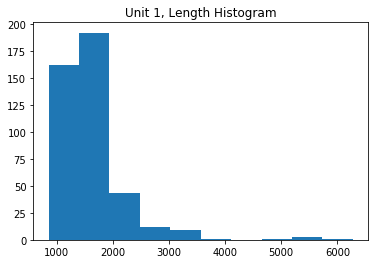

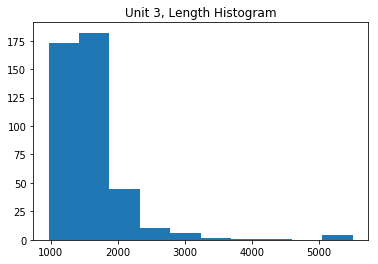

In [21]:
for unitSelect in ['1', '3']:

    unitData = defaultdict(list)

    if "unit{}Data.pickle".format(unitSelect) in os.listdir("units/"):
        with open("units/unit{}Data.pickle".format(unitSelect), "rb") as infile:
            unitData = pickle.load(infile)
        plt.hist([len(item[0]['values']) for _, item in unitData.items()])
        plt.title("Unit {}, Length Histogram".format(unitSelect))
        plt.show()
    else:
        print("Collecting Unit {}:".format(unitSelect))
        for BatchId in allIDs:
            with open("recipe421/{}.pickle".format(BatchId), "rb") as infile:
                batch = pickle.load(infile)

            start = batch['Units'][unitSelect]["BaeSTime"]
            end = batch['Units'][unitSelect]["BaeETime"]
            for tagName in unitsPVs[unitSelect]:
                unitData[BatchId].append(get_pv_values(pvlist = tagName, starttime = formatTime(start), endtime = formatTime(end)))
            print(BatchId, end = " ")

        with open("units/unit{}Data.pickle".format(unitSelect), 'wb') as handle:
            pickle.dump(unitData, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        plt.hist([len(item[0]['values']) for _, item in unitData.items()])
        plt.title("Unit {}, Length Histogram".format(unitSelect))
        plt.show()

For both units the data are quite long, this could cause an extremely long computation time to select variables. For this, I first try with a subsample of 50 batches, assessing the time to compute all the single variate distances.

In [22]:
with open("units/unit{}Data.pickle".format(3), "rb") as infile:
    unitData = pickle.load(infile)

unit3IDs = list(unitData.keys())

random.setstate(state)
random.shuffle(unit3IDs)

The following function performs DTW calculation on a certain set of batches. Since the distance metric and the step pattern are both symmetric, the DTW distance is symmetric so it is possible tu calculate just half of the combinations.

In [23]:
# Parallel algorithm
def processBatch(BatchId, unitData, tagName, unit):
    if "{}.csv".format(BatchId) in os.listdir("units/selectVars/{}/{}/".format(unit, tagName)):
        return
    else:
        unitDataSV = copy.deepcopy(unitData)

        IDs = sorted([key for key in unitDataSV.keys() if isinstance(key, int)])
        toPop = [_id for _id in IDs if _id < BatchId]
        if len(IDs) - len(toPop) < 2:
            return

        for _id in toPop:
            _ = unitDataSV.pop(_id) 

        unitDataSV['reference'] = BatchId

        res = dtw(jsonObj = unitDataSV, 
          open_ended = False, 
          all_subseq = False, 
          only_distance = True, 
          dist_measure = "euclidean",
          scale = True,
          low_filter = False,
          shapeDTW = False,
          shape_descriptor = "raw",
          n_points_shape = 61,
          norm_dist = True,
          undersampling = False,
          undersampling_factor = 1,
          n_jobs = 1)

        res.ApplyDTW()

        results = [item[0] for key, item in res.output.items()]
        df = pd.DataFrame(results)
        df.to_csv("units/selectVars/{}/{}/{}.csv".format(unit, tagName, BatchId), index = False)
    return

In [24]:
unit = '3'
J = len(unitsPVs[unit])
try:
    os.mkdir("units/selectVars/{}".format(unit))
except: pass
PVdict = dict()
for j in range(J):
    tagName = unitData[5082][j]['name']
    PVdict[tagName] = j

In [25]:
num_jobs = multiprocessing.cpu_count()
K = 8

J = len(unitsPVs[unit])
selectedIDs = sorted(unit3IDs[:K])
    
start = time.time()

for j in range(J):
    clear_output()
    unitDataSV = dict()

    for _id in selectedIDs:
        unitDataSV[_id] = [unitData[_id][j]]
        tagName = unitData[_id][j]['name']
    PVdict[tagName] = j
    try:
        os.mkdir("units/selectVars/{}/{}".format(unit, tagName))
    except:
        pass
    
    print(tagName, j+1)

    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataSV, tagName, unit)
    if not len(IDsToDo):
        pass
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataSV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

Total elapsed time for 8 Batches, 95 Variable(s): 0 seconds


Next step is to sum all the distances for each variable, the one with the smallest total distance will be considered the most stable and will be selected. We also have to store this total distance for future variable selection

In [26]:
pvDist = list()
for filenamePV in os.listdir("units/selectVars/{}/".format(unit)):
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        try:
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
        except: pass
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(*pvDist)

(0.0, 'ba_FC1QXXKX5Gx', 56) (0.0, 'ba_FC2ctjhXa5mu', 11) (0.0, 'ba_FC2mSh7aqR37Ye', 22) (0.0, 'ba_FC7TgkJodnV6', 82) (0.0, 'ba_FC9ME50lj', 36) (0.0, 'ba_FC9VnTk6', 28) (0.0, 'ba_FCHDU0E38R9su4E', 42) (0.0, 'ba_FCHf358e123AU', 21) (0.0, 'ba_FCJTGzlWjneoKMY6G', 86) (0.0, 'ba_FCMidwB6QVLn', 0) (0.0, 'ba_FCO5zQuMrAt', 77) (0.0, 'ba_FCPLwZp2hAH5lu', 91) (0.0, 'ba_FCTDbXyiQC7', 78) (0.0, 'ba_FCTwxOzL8Ow7fX', 55) (0.0, 'ba_FCVA5QsiiOXe4', 35) (0.0, 'ba_FCYrQ4PQs8TfgOEW', 46) (0.0, 'ba_FCZRM8lDxm9', 60) (0.0, 'ba_FCZwV34eH', 13) (0.0, 'ba_FCbhlHzOOkhs5', 52) (0.0, 'ba_FCc9YS2tP', 62) (0.0, 'ba_FCfTMuJZwI', 51) (0.0, 'ba_FCgkgqssVyJO', 74) (0.0, 'ba_FCxuvEtxfRbcCa', 17) (0.0, 'ba_FCzdTgwTGIt', 19) (0.0, 'ba_FQPDzN', 40) (0.0, 'ba_FQRSOHyE21rZOXsKhJE', 81) (0.0, 'ba_FQrej6GJ5vPvJ', 39) (0.0, 'ba_FQvnd0yXKAbL5X', 26) (0.0, 'ba_FpxlMOAyc5', 33) (0.0, 'ba_PCqRL4yvS3bClutA', 66) (0.0, 'ba_TCOP0V4Rcn', 48) (0.0, 'ba_TClpO5', 61) (0.009524965489748263, 'ba_PCGd0srEZp', 76) (0.013924492635723032, 'ba_F

Many total distance are 0. This suggests that there are variables with a costant value, and so these are non-informative variables. Those should be removed from the data. 

In [27]:
PVtoRemove = list()
for j in range(J):
    var = 0.0
    for _id, pvs in unitData.items():
        var = max(var, np.var(pvs[j]['values']))
    if var <= 1e-6:
        PVtoRemove.append((pvs[j]['name'], j))
len(PVtoRemove)

21

There are 21 non-informative (constant) variables. These have to be removed from the data.

In [28]:
unitDataNew = dict()
for _id, pvs in unitData.items():
    unitDataNew[_id] = [pvs[j] for j in range(J) if j not in [k for name, k in PVtoRemove]]
len(unitDataNew[5082])

74

It's possible to discard the computation performed for that 21 variables:

In [29]:
for pv, j in PVtoRemove:
    _ = PVdict.pop(pv)
len(PVdict.keys())

74

We can now continue the analysis as before.

In [30]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/".format(unit)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        try:
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
        except: pass
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.0, 'ba_FC2ctjhXa5mu', 11), (0.0, 'ba_FC2mSh7aqR37Ye', 22), (0.0, 'ba_FCHDU0E38R9su4E', 42), (0.0, 'ba_FCTwxOzL8Ow7fX', 55), (0.0, 'ba_FCVA5QsiiOXe4', 35), (0.0, 'ba_FCZwV34eH', 13), (0.0, 'ba_FQPDzN', 40), (0.0, 'ba_FQrej6GJ5vPvJ', 39), (0.0, 'ba_FpxlMOAyc5', 33), (0.0, 'ba_PCqRL4yvS3bClutA', 66), (0.0, 'ba_TClpO5', 61), (0.009524965489748263, 'ba_PCGd0srEZp', 76), (0.013924492635723032, 'ba_FQkqszuusF7QDi', 50), (0.01741574727564904, 'ba_F8szer', 59), (0.022484933834305425, 'ba_FQlpPE', 15), (0.05424849380257319, 'ba_F0zhz6e', 84), (0.05472039707193263, 'ba_FIhgSwHD', 83), (0.061791296847798854, 'ba_FC8fHeBVpUFncPI', 4), (0.0849573161152044, 'ba_PCSTgdwK3V', 65), (0.08765613357446791, 'ba_FQraEXT', 25), (0.10158611087169633, 'ba_F4vtJ1', 31), (0.10817966292019485, 'ba_FCrBDixZDXjb', 72), (0.12353108548660141, 'ba_FCsYgvPgi0N', 80), (0.1533650857876657, 'ba_FCobtZJfb5TG', 49), (0.17912867646325167, 'ba_FC3BnZ', 7), (0.23375324345817228, 'ba_FCgrPs', 90), (0.32647567179331244, 'ba_F

74

Certain variables still have zero DTW distance, but as checked before, these are not constant for all variables. It's worth to perform again the analysis and see if they appear again, choosing different batches (more data points).

In [31]:
unit = '3-2ndRound'
PVdict = dict()
J = len(unitDataNew[5082])
for j in range(J):
    tagName = unitDataNew[5082][j]['name']
    PVdict[tagName] = j
random.shuffle(unit3IDs) 

In [ ]:
num_jobs = multiprocessing.cpu_count()
K = 8
try:
    os.mkdir("units/selectVars/{}".format(unit))
except: pass


selectedIDs = sorted(unit3IDs[:K])

start = time.time()

for j in range(J):
    clear_output()
    unitDataSV = dict()

    for _id in selectedIDs:
        unitDataSV[_id] = [unitDataNew[_id][j]]
        tagName = unitDataNew[_id][j]['name']
    PVdict[tagName] = j
    try:
        os.mkdir("units/selectVars/{}/{}".format(unit, tagName))
    except:
        pass
    
    print(tagName, j+1)

    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataSV, tagName, unit)
    if not len(IDsToDo):
        pass
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataSV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

In [33]:
pvDist = list()
for filenamePV in os.listdir("units/selectVars/{}/".format(unit)):
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        if filenameDTW.endswith(".csv"):
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
print(len(pvDist))

[(0.0, 'ba_FC2ctjhXa5mu', 10), (0.0, 'ba_FCTwxOzL8Ow7fX', 44), (0.0, 'ba_FCVA5QsiiOXe4', 29), (0.0, 'ba_FCZwV34eH', 12), (0.0, 'ba_FQPDzN', 33), (0.0, 'ba_PCqRL4yvS3bClutA', 52), (0.0, 'ba_TClpO5', 48), (0.029619332692785112, 'ba_F8szer', 47), (0.034472307369087345, 'ba_PCGd0srEZp', 61), (0.046641942366856655, 'ba_FQkqszuusF7QDi', 41), (0.056113479132456213, 'ba_FCHDU0E38R9su4E', 35), (0.06808796353808236, 'ba_F0zhz6e', 65), (0.10209639728008604, 'ba_FIhgSwHD', 64), (0.12353108548660141, 'ba_FCsYgvPgi0N', 63), (0.2110276152698617, 'ba_FC7fl4f1HT5', 53), (0.2405253805820691, 'ba_FC8fHeBVpUFncPI', 3), (0.2580281777249569, 'ba_F4vtJ1', 25), (0.26000044454772503, 'ba_FCrBDixZDXjb', 58), (0.3183836461546509, 'ba_PCSTgdwK3V', 51), (0.6337364889816344, 'ba_FC3BnZ', 6), (0.6989137922462023, 'ba_FCgrPs', 70), (0.7353735309760395, 'ba_FCobtZJfb5TG', 40), (0.7831339557918368, 'ba_FC2mSh7aqR37Ye', 18), (0.8377498480145926, 'ba_Fl7pvjqC', 59), (0.9396776752946429, 'ba_PCPUSq5ah', 4), (1.00437539194

HYPOTHESIS: PVs with DTW distance equal to 0 are non informative because they take on just few constant values, that repeat in the same order in all the batches, so the resulting dtw distance is 0. Let's check 

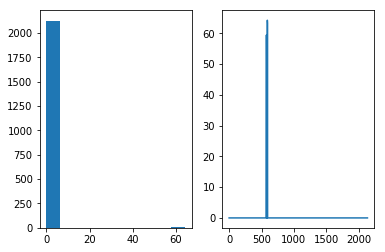

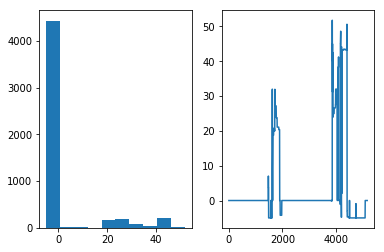

In [34]:
for _id in unitDataNew.keys():
    dt = unitDataNew[_id][12]['values']
    if np.var(dt) <= 1e-6: continue
    else:
        fig, (ax0, ax1) = plt.subplots(1,2)
        ax0.hist(dt)
        ax1.plot(dt)
        plt.show()

Visually analyzing the distribution and trend over time of the zero DTW distance variables, I give here some reasons why I discard certain variables and not others.

To discard:
* 'ba_FC2ctjhXa5mu', 10: always constant except for a spike in one point of a single batch
* 'ba_FCVA5QsiiOXe4', 29: always constant except for a spike in one point of a single batch
* 'ba_FCZwV34eH', 12: non constant only in 2 batches
* 'ba_FQPDzN', 33: non constant trend only in 1 batch
* 'ba_TClpO5', 48: single spike in 2 batches


Not to discard:
* 'ba_FC2mSh7aqR37Ye', 18: presents an abnormal behaviour in one batch; in general is non constant in 3 batches
* 'ba_FC7fl4f1HT5', 53: complex trend in many batches
* 'ba_FCGUglDXyPKrnk38', 2: non constant trend in many batches
* 'ba_FCHDU0E38R9su4E', 35: spikes inmany bacthes
* 'ba_FCsYgvPgi0N', 63: relevant spikes in 4 batches
* 'ba_FQADMQfb0z', 73: non constant trend in many batches
* 'ba_FQC6tzztBV4DeXemfp', 68: relevant spikes in many batches
* 'ba_FQrej6GJ5vPvJ', 32: relevant spikes in many batches
* 'ba_FpxlMOAyc5', 27: complex trend in many batches
* 'ba_PCqRL4yvS3bClutA', 52: relevant spikes in many batches
* 'ba_TCxXXPBmWNldwyD', 28: non constant trend in many batches

The situation should be further analysed to better select the non-informative variables. For the moment, I __DISCARD__ the five variables listed above and add data points to the others, wishing to remove the zero distance cases, since starting with a 0 baseline as distance would probably not allow further selection.

In [35]:
PVtoRemove = [10, 29, 12, 33, 48]

unitDataClean1 = dict()

for _id, pvs in unitDataNew.items():
    unitDataClean1[_id] = [pvs[j] for j in range(J) if j not in PVtoRemove]
len(unitDataClean1[5083])

69

In [36]:
#unit = '3'
PVdict = dict()
num_jobs = multiprocessing.cpu_count()
K = 8
#unit3IDs = [5472, 5471, 5417, 5393, 5405, 5178, 5372, 5469, 5344, 5336, 5315, 5273, 5168, 5202, 5477]
J = len(unitDataClean1[5082])
selectedIDs = sorted(unit3IDs[K-1:2*K])
selectedIDs

start = time.time()
for j in range(J):
    tagName = unitDataClean1[5083][j]['name']
    PVdict[tagName] = j

In [ ]:
for j in range(J):
    clear_output()
    unitDataSV = dict()

    for _id in selectedIDs:
        unitDataSV[_id] = [unitDataClean1[_id][j]]
        tagName = unitDataClean1[_id][j]['name']
    PVdict[tagName] = j
    try:
        os.mkdir("units/selectVars/{}/{}".format(unit, tagName))
    except:
        pass
    
    print(tagName, "{}/{}".format(j+1, J))

    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataSV, tagName, unit)
    if not len(IDsToDo):
        pass
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataSV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

In [37]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/".format(unit)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        try:
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
        except: pass
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.0, 'ba_FCTwxOzL8Ow7fX', 40), (0.0, 'ba_PCqRL4yvS3bClutA', 47), (0.029619332692785112, 'ba_F8szer', 43), (0.034472307369087345, 'ba_PCGd0srEZp', 56), (0.046641942366856655, 'ba_FQkqszuusF7QDi', 37), (0.056113479132456213, 'ba_FCHDU0E38R9su4E', 31), (0.06808796353808236, 'ba_F0zhz6e', 60), (0.10209639728008604, 'ba_FIhgSwHD', 59), (0.12353108548660141, 'ba_FCsYgvPgi0N', 58), (0.2110276152698617, 'ba_FC7fl4f1HT5', 48), (0.2405253805820691, 'ba_FC8fHeBVpUFncPI', 3), (0.2580281777249569, 'ba_F4vtJ1', 23), (0.26000044454772503, 'ba_FCrBDixZDXjb', 53), (0.3183836461546509, 'ba_PCSTgdwK3V', 46), (0.6337364889816344, 'ba_FC3BnZ', 6), (0.6989137922462023, 'ba_FCgrPs', 65), (0.7353735309760395, 'ba_FCobtZJfb5TG', 36), (0.7831339557918368, 'ba_FC2mSh7aqR37Ye', 16), (0.8377498480145926, 'ba_Fl7pvjqC', 54), (0.9396776752946429, 'ba_PCPUSq5ah', 4), (1.0043753919447371, 'ba_FCedKru8pHF7Ae1BA6QR', 35), (1.009620579258733, 'ba_TDZV2zDOrmiYP', 28), (1.1557899878530868, 'ba_FCBbekJeA7', 32), (1.234034

69

Still zero distance variables. Adding data points

In [ ]:
#unit = '3'
PVdict = dict()
num_jobs = multiprocessing.cpu_count()
K = 8
#unit3IDs = [5472, 5471, 5417, 5393, 5405, 5178, 5372, 5469, 5344, 5336, 5315, 5273, 5168, 5202, 5477]
J = len(unitDataClean1[5082])
#selectedIDs = random.sample(unit3IDs, K)
selectedIDs = sorted(selectedIDs)

start = time.time()

for j in range(J):
    clear_output()
    unitDataSV = dict()

    for _id in selectedIDs:
        unitDataSV[_id] = [unitDataClean1[_id][j]]
        tagName = unitDataClean1[_id][j]['name']
    PVdict[tagName] = j
    try:
        os.mkdir("units/selectVars/{}/{}".format(unit, tagName))
    except:
        pass
    
    print(tagName, "{}/{}".format(j+1, J))

    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataSV, tagName, unit)
    if not len(IDsToDo):
        pass
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataSV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

In [38]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/".format(unit)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        try:
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
        except: pass
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.0, 'ba_FCTwxOzL8Ow7fX', 40), (0.0, 'ba_PCqRL4yvS3bClutA', 47), (0.029619332692785112, 'ba_F8szer', 43), (0.034472307369087345, 'ba_PCGd0srEZp', 56), (0.046641942366856655, 'ba_FQkqszuusF7QDi', 37), (0.056113479132456213, 'ba_FCHDU0E38R9su4E', 31), (0.06808796353808236, 'ba_F0zhz6e', 60), (0.10209639728008604, 'ba_FIhgSwHD', 59), (0.12353108548660141, 'ba_FCsYgvPgi0N', 58), (0.2110276152698617, 'ba_FC7fl4f1HT5', 48), (0.2405253805820691, 'ba_FC8fHeBVpUFncPI', 3), (0.2580281777249569, 'ba_F4vtJ1', 23), (0.26000044454772503, 'ba_FCrBDixZDXjb', 53), (0.3183836461546509, 'ba_PCSTgdwK3V', 46), (0.6337364889816344, 'ba_FC3BnZ', 6), (0.6989137922462023, 'ba_FCgrPs', 65), (0.7353735309760395, 'ba_FCobtZJfb5TG', 36), (0.7831339557918368, 'ba_FC2mSh7aqR37Ye', 16), (0.8377498480145926, 'ba_Fl7pvjqC', 54), (0.9396776752946429, 'ba_PCPUSq5ah', 4), (1.0043753919447371, 'ba_FCedKru8pHF7Ae1BA6QR', 35), (1.009620579258733, 'ba_TDZV2zDOrmiYP', 28), (1.1557899878530868, 'ba_FCBbekJeA7', 32), (1.234034

69

In [ ]:
#unit = '3'
PVdict = dict()
num_jobs = multiprocessing.cpu_count()
K = 8
#unit3IDs = [5472, 5471, 5417, 5393, 5405, 5178, 5372, 5469, 5344, 5336, 5315, 5273, 5168, 5202, 5477]
J = len(unitDataClean1[5082])

selectedIDs = sorted(random.sample(unit3IDs, K))

start = time.time()

for j in range(J):
    clear_output()
    unitDataSV = dict()

    for _id in selectedIDs:
        unitDataSV[_id] = [unitDataClean1[_id][j]]
        tagName = unitDataClean1[_id][j]['name']
    PVdict[tagName] = j
    try:
        os.mkdir("units/selectVars/{}/{}".format(unit, tagName))
    except:
        pass
    
    print(tagName, "{}/{}".format(j+1, J))

    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataSV, tagName, unit)
    if not len(IDsToDo):
        pass
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataSV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/{}/".format(unit, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

In [39]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/".format(unit)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/{}".format(unit, filenamePV)):
        try:
            df = pd.read_csv("units/selectVars/{}/{}/{}".format(unit, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
        except: pass
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.0, 'ba_FCTwxOzL8Ow7fX', 40), (0.0, 'ba_PCqRL4yvS3bClutA', 47), (0.029619332692785112, 'ba_F8szer', 43), (0.034472307369087345, 'ba_PCGd0srEZp', 56), (0.046641942366856655, 'ba_FQkqszuusF7QDi', 37), (0.056113479132456213, 'ba_FCHDU0E38R9su4E', 31), (0.06808796353808236, 'ba_F0zhz6e', 60), (0.10209639728008604, 'ba_FIhgSwHD', 59), (0.12353108548660141, 'ba_FCsYgvPgi0N', 58), (0.2110276152698617, 'ba_FC7fl4f1HT5', 48), (0.2405253805820691, 'ba_FC8fHeBVpUFncPI', 3), (0.2580281777249569, 'ba_F4vtJ1', 23), (0.26000044454772503, 'ba_FCrBDixZDXjb', 53), (0.3183836461546509, 'ba_PCSTgdwK3V', 46), (0.6337364889816344, 'ba_FC3BnZ', 6), (0.6989137922462023, 'ba_FCgrPs', 65), (0.7353735309760395, 'ba_FCobtZJfb5TG', 36), (0.7831339557918368, 'ba_FC2mSh7aqR37Ye', 16), (0.8377498480145926, 'ba_Fl7pvjqC', 54), (0.9396776752946429, 'ba_PCPUSq5ah', 4), (1.0043753919447371, 'ba_FCedKru8pHF7Ae1BA6QR', 35), (1.009620579258733, 'ba_TDZV2zDOrmiYP', 28), (1.1557899878530868, 'ba_FCBbekJeA7', 32), (1.234034

69

The PVs 'ba_FCTwxOzL8Ow7fX' and 'ba_PCqRL4yvS3bClutA' still show 0 DTW distance. I decide to remove them from the set of PVs and proceed to bi-variate DTW, with 'ba_F8szer' as selected variable.

In [40]:
PVtoRemove = [40, 47]

unitDataClean2 = dict()

for _id, pvs in unitDataClean1.items():
    unitDataClean2[_id] = [pvs[j] for j in range(J) if j not in PVtoRemove]
len(unitDataClean2[5083])

67

In [46]:
PVdict = dict()
J = len(unitDataClean2[5082])
for j in range(J):
    tagName = unitDataClean2[5082][j]['name']
    PVdict[tagName] = j
bestPV = 'ba_F8szer'
jStar = PVdict[bestPV]
jStar

42

In [42]:
def processBatch(BatchId, unitData, tagName, unit):
    if "{}.csv".format(BatchId) in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName)):
        return
    else:
        unitDataSV = copy.deepcopy(unitData)

        IDs = sorted([key for key in unitDataSV.keys() if isinstance(key, int)])
        toPop = [_id for _id in IDs if _id < BatchId]
        if len(IDs) - len(toPop) < 2:
            return

        for _id in toPop:
            _ = unitDataSV.pop(_id) 

        unitDataSV['reference'] = BatchId

        res = dtw(jsonObj = unitDataSV, 
          open_ended = False, 
          all_subseq = False, 
          only_distance = True, 
          dist_measure = "euclidean",
          scale = True,
          low_filter = False,
          shapeDTW = False,
          shape_descriptor = "raw",
          n_points_shape = 61,
          norm_dist = True,
          undersampling = False,
          undersampling_factor = 1,
          n_jobs = 1)

        res.ApplyDTW()

        results = [item[0] for key, item in res.output.items()]
        df = pd.DataFrame(results)
        df.to_csv("units/selectVars/{}/BEST{}/{}/{}.csv".format(unit,bestPV, tagName, BatchId), index = False)
    return

In [44]:
# Parallel algorithm

unit = '3-2'

num_jobs = multiprocessing.cpu_count()
K = 8

selectedIDs = sorted(unit3IDs[K:2K])

try: os.mkdir("units/selectVars/{}/".format(unit))
except: pass
    
try: os.mkdir("units/selectVars/{}/BEST{}".format(unit, bestPV))
except: pass
    
start = time.time()
for j in range(J):
    tagName = unitDataClean2[5083][j]['name']
    PVdict[tagName] = j
    

In [ ]:
for j in range(J):
    if j == jStar: continue
        
    clear_output()
    unitDataBV = dict()

    for _id in selectedIDs:
        unitDataBV[_id] = [unitDataClean2[_id][jStar], unitDataClean2[_id][j]]
        tagName = unitDataClean2[_id][j]['name']
    PVdict[tagName] = j
    
    print(tagName, "{}/{}".format(j+1, J))
    
    try:
        os.mkdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))
    except:
        pass
    
    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataBV, tagName, unit)
    if not len(IDsToDo):
        pass
    
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataBV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

In [47]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/BEST{}/".format(unit, bestPV)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, filenamePV)):
        if filenameDTW.endswith(".csv"):
            df = pd.read_csv("units/selectVars/{}/BEST{}/{}/{}".format(unit, bestPV, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.005619433119274127, 'ba_FC2mSh7aqR37Ye', 16), (0.005619433119274127, 'ba_FC7fl4f1HT5', 46), (0.005619433119274127, 'ba_FCHDU0E38R9su4E', 31), (0.005619433119274127, 'ba_FCsYgvPgi0N', 56), (0.005619433119274127, 'ba_FQT7dzM2wq51Z3JW', 43), (0.005619433119274127, 'ba_FpxlMOAyc5', 25), (0.010320680208213999, 'ba_PCGd0srEZp', 54), (0.012707815287683756, 'ba_FQkqszuusF7QDi', 37), (0.027379984545159303, 'ba_F0zhz6e', 58), (0.02766629932610572, 'ba_FIhgSwHD', 57), (0.031915067072114126, 'ba_FQlpPE', 12), (0.03765463278544326, 'ba_FC8fHeBVpUFncPI', 3), (0.044628442965256046, 'ba_F4vtJ1', 23), (0.05307463083672267, 'ba_FQraEXT', 19), (0.05764341248705097, 'ba_FCrBDixZDXjb', 51), (0.0649683946364562, 'ba_PCSTgdwK3V', 45), (0.10324202658671341, 'ba_PCPUSq5ah', 4), (0.11291039276977069, 'ba_PYQtZYPJC2Ghw', 1), (0.11656693706138725, 'ba_Fl7pvjqC', 52), (0.13139246253435996, 'ba_TDZyHMh1UZ', 20), (0.1314962624975127, 'ba_TCkwAse0bopy8zp6', 40), (0.13793560201370392, 'ba_FCobtZJfb5TG', 36), (0.14

66

Looking at the variables 'ba_FC2mSh7aqR37Ye', 'ba_FC7fl4f1HT5', 'ba_FCHDU0E38R9su4E', 'ba_FCsYgvPgi0N', 'ba_FQT7dzM2wq51Z3JW', 'ba_FpxlMOAyc5,' we see that their total distance is lower than the one for single variate dtw. We need to add more data points to isolate only one combination.

In [49]:
selectedIDs = sorted(unit3IDs[K:2*K])
for j in [16, 46, 31, 56, 43, 25]:
    
    if j == jStar: continue
        
    clear_output()
    unitDataBV = dict()

    for _id in selectedIDs:
        unitDataBV[_id] = [unitDataClean2[_id][jStar], unitDataClean2[_id][j]]
        tagName = unitDataClean2[_id][j]['name']
    PVdict[tagName] = j
    
    print(tagName, "{}/{}".format(j+1, J))
    
    try:
        os.mkdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))
    except:
        pass
    
    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataBV, tagName, unit)
    if not len(IDsToDo):
        pass
    
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataBV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

Total elapsed time for 8 Batches, 67 Variable(s): 1121 seconds


In [50]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/BEST{}/".format(unit, bestPV)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, filenamePV)):
        if filenameDTW.endswith(".csv"):
            df = pd.read_csv("units/selectVars/{}/BEST{}/{}/{}".format(unit, bestPV, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.008665640965141056, 'ba_FC2mSh7aqR37Ye', 16), (0.008665640965141056, 'ba_FCHDU0E38R9su4E', 31), (0.008665640965141056, 'ba_FCsYgvPgi0N', 56), (0.008665640965141056, 'ba_FpxlMOAyc5', 25), (0.010320680208213999, 'ba_PCGd0srEZp', 54), (0.012707815287683756, 'ba_FQkqszuusF7QDi', 37), (0.027379984545159303, 'ba_F0zhz6e', 58), (0.02766629932610572, 'ba_FIhgSwHD', 57), (0.031915067072114126, 'ba_FQlpPE', 12), (0.03765463278544326, 'ba_FC8fHeBVpUFncPI', 3), (0.044628442965256046, 'ba_F4vtJ1', 23), (0.05307463083672267, 'ba_FQraEXT', 19), (0.05764341248705097, 'ba_FCrBDixZDXjb', 51), (0.0649683946364562, 'ba_PCSTgdwK3V', 45), (0.10324202658671341, 'ba_PCPUSq5ah', 4), (0.11291039276977069, 'ba_PYQtZYPJC2Ghw', 1), (0.11656693706138725, 'ba_Fl7pvjqC', 52), (0.13139246253435996, 'ba_TDZyHMh1UZ', 20), (0.1314962624975127, 'ba_TCkwAse0bopy8zp6', 40), (0.13351903909754878, 'ba_FC7fl4f1HT5', 46), (0.13793560201370392, 'ba_FCobtZJfb5TG', 36), (0.1450831359640795, 'ba_TDZV2zDOrmiYP', 28), (0.15333687

66

In [51]:
selectedIDs = sorted(unit3IDs[2*K:3*K])
for j in [16, 31, 56, 25]:
    
    if j == jStar: continue
        
    clear_output()
    unitDataBV = dict()

    for _id in selectedIDs:
        unitDataBV[_id] = [unitDataClean2[_id][jStar], unitDataClean2[_id][j]]
        tagName = unitDataClean2[_id][j]['name']
    PVdict[tagName] = j
    
    print(tagName, "{}/{}".format(j+1, J))
    
    try:
        os.mkdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))
    except:
        pass
    
    IDsToDo = [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))]
    if len(IDsToDo) == 1:
        processBatch(IDsToDo[0], unitDataBV, tagName, unit)
    if not len(IDsToDo):
        pass
    
    else:
        _ = Parallel(n_jobs=num_jobs, verbose = 50)(delayed(processBatch)(BatchId, unitDataBV, tagName, unit) 
                                                for BatchId in [_id for _id in selectedIDs[:-1] if "{}.csv".format(_id) not in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, tagName))])

clear_output()

print("Total elapsed time for {} Batches, {} Variable(s): {:.0f} seconds".format(K, J, time.time() - start))

Total elapsed time for 8 Batches, 67 Variable(s): 1450 seconds


In [52]:
pvDist = list()
PVselected = [filenamePV for filenamePV in os.listdir("units/selectVars/{}/BEST{}/".format(unit, bestPV)) if filenamePV in PVdict.keys()]

for filenamePV in PVselected:
    dist = 0
    for filenameDTW in os.listdir("units/selectVars/{}/BEST{}/{}".format(unit, bestPV, filenamePV)):
        if filenameDTW.endswith(".csv"):
            df = pd.read_csv("units/selectVars/{}/BEST{}/{}/{}".format(unit, bestPV, filenamePV, filenameDTW), header = 0)
            dist += sum(df.DTW_dist)
    pvDist.append((dist, filenamePV, PVdict[filenamePV]))
pvDist = sorted(pvDist)
print(pvDist)
len(pvDist)

[(0.010320680208213999, 'ba_PCGd0srEZp', 54), (0.011835815911324835, 'ba_FCsYgvPgi0N', 56), (0.011835815911324835, 'ba_FpxlMOAyc5', 25), (0.012707815287683756, 'ba_FQkqszuusF7QDi', 37), (0.027379984545159303, 'ba_F0zhz6e', 58), (0.02766629932610572, 'ba_FIhgSwHD', 57), (0.031915067072114126, 'ba_FQlpPE', 12), (0.03765463278544326, 'ba_FC8fHeBVpUFncPI', 3), (0.044628442965256046, 'ba_F4vtJ1', 23), (0.05307463083672267, 'ba_FQraEXT', 19), (0.05764341248705097, 'ba_FCrBDixZDXjb', 51), (0.0649683946364562, 'ba_PCSTgdwK3V', 45), (0.10324202658671341, 'ba_PCPUSq5ah', 4), (0.11291039276977069, 'ba_PYQtZYPJC2Ghw', 1), (0.11656693706138725, 'ba_Fl7pvjqC', 52), (0.13139246253435996, 'ba_TDZyHMh1UZ', 20), (0.1314962624975127, 'ba_TCkwAse0bopy8zp6', 40), (0.13351903909754878, 'ba_FC7fl4f1HT5', 46), (0.13793560201370392, 'ba_FCobtZJfb5TG', 36), (0.1450831359640795, 'ba_TDZV2zDOrmiYP', 28), (0.1533368716148001, 'ba_FCgrPs', 63), (0.16440098865255912, 'ba_FQ68FvvUHzgUeA', 60), (0.17145012903748125, '

66